In [1]:
import torch
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#画图准备
accuracy_result=[]

In [3]:
#导入数据集
batch_size=64
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.1307],std=[0.3081])])
train_data=datasets.MNIST(root='C:/Users/Administrator/Desktop/datasets/Mnist_download',train=True,download=False,transform=transform)
train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_data=datasets.MNIST(root='C:/Users/Administrator/Desktop/datasets/Mnist_download',train=False,download=False,transform=transform)
test_loader=DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [4]:
#Inception Module
class InceptionA(torch.nn.Module):
    def __init__(self,in_channels_size):
        super(InceptionA,self).__init__()
        self.Avg_Pooling=torch.nn.AvgPool2d(kernel_size=3,stride=1,padding=1)
        self.Conv1x1_1=torch.nn.Conv2d(in_channels_size,24,kernel_size=1)
        
        self.Conv1x1_2=torch.nn.Conv2d(in_channels_size,16,kernel_size=1)

        self.Conv5x5=torch.nn.Conv2d(16,24,kernel_size=5,padding=2)
        
        self.Conv3x3_1=torch.nn.Conv2d(16,24,kernel_size=3,padding=1)
        self.Conv3x3_2=torch.nn.Conv2d(24,24,kernel_size=3,padding=1)
        
    def forward(self,x):
        branch1=self.Avg_Pooling(x)
        branch1=self.Conv1x1_1(branch1)

        branch2=self.Conv1x1_2(x)
        
        branch3=self.Conv1x1_2(x)
        branch3=self.Conv5x5(branch3)

        branch4=self.Conv1x1_2(x)
        branch4=self.Conv3x3_1(branch4)
        branch4=self.Conv3x3_2(branch4)

        result=torch.cat([branch1,branch2,branch3,branch4],dim=1)
        return result
# Inception=InceptionA(in_channels_size=1)
# input=torch.randn(1,1,28,28)
# output=Inception(input)
# print(output.shape)

In [5]:
#Net
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.Conv1=torch.nn.Conv2d(1,10,kernel_size=5)
        self.MaxPool=torch.nn.MaxPool2d(2)
        self.incept1=InceptionA(10)
        self.Conv2=torch.nn.Conv2d(88,20,kernel_size=5)
        self.incept2=InceptionA(20)
        self.fc=torch.nn.Linear(1408,10)

    def forward(self,x):
        batch_size=x.size(0)
        x=self.Conv1(x)
        x=F.relu(self.MaxPool(x))
        x=self.incept1(x)
        x=self.Conv2(x)
        x=F.relu(self.MaxPool(x))
        x=self.incept2(x)
        x=x.view(batch_size,-1)
        x=self.fc(x)
        return x
# model=Net()
# x=torch.randn(1,1,28,28)
# y=model(x)
# print(y.shape)
model1=Net1()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)

Net1(
  (Conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (incept1): InceptionA(
    (Avg_Pooling): AvgPool2d(kernel_size=3, stride=1, padding=1)
    (Conv1x1_1): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
    (Conv1x1_2): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (Conv5x5): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Conv3x3_1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv3x3_2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incept2): InceptionA(
    (Avg_Pooling): AvgPool2d(kernel_size=3, stride=1, padding=1)
    (Conv1x1_1): Conv2d(20, 24, kernel_size=(1, 1), stride=(1, 1))
    (Conv1x1_2): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (Conv5x5): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (

In [6]:
#定义损失和优化
criterion=torch.nn.CrossEntropyLoss()
optimizer=optim.SGD(model1.parameters(),lr=0.01,momentum=0.5)

In [7]:
#定义训练和测试
def train(epoch):
    loss_running=0.0
    for i,data in enumerate(train_loader,0):
        input,labels=data #prepare data
        input,labels=input.to(device),labels.to(device)
        output=model1(input) #forward
        loss=criterion(output,labels)
        optimizer.zero_grad() 
        loss.backward() #backward
        optimizer.step() #updata
        loss_running+=loss.item()
        if i%300==299:
            print("[%d,%d],average_loss is:%.4f"%(epoch+1,i+1,loss_running/200))
            loss_running=0
def test():
    correct=0
    total=0
    with torch.no_grad():
        for data in test_loader:
            input,labels=data
            input,labels=input.to(device),labels.to(device)
            output=model1(input)
            output=torch.max(output,dim=1)
            correct+=torch.sum(output.indices==labels).item()
            total+=labels.size(0)
        print("The test_data accuracy is:%.4f"%(correct/total))
        accuracy_result.append(correct/total)      

In [8]:
if __name__=='__main__':
    for epoch in range(10):
        train(epoch)
        test()

[1,300],average_loss is:1.3252
[1,600],average_loss is:0.3400
[1,900],average_loss is:0.2441
The test_data accuracy is:0.9674
[2,300],average_loss is:0.1770
[2,600],average_loss is:0.1535
[2,900],average_loss is:0.1355
The test_data accuracy is:0.9761
[3,300],average_loss is:0.1231
[3,600],average_loss is:0.1209
[3,900],average_loss is:0.1034
The test_data accuracy is:0.9811
[4,300],average_loss is:0.0931
[4,600],average_loss is:0.0972
[4,900],average_loss is:0.0980
The test_data accuracy is:0.9800
[5,300],average_loss is:0.0802
[5,600],average_loss is:0.0864
[5,900],average_loss is:0.0841
The test_data accuracy is:0.9851
[6,300],average_loss is:0.0739
[6,600],average_loss is:0.0789
[6,900],average_loss is:0.0703
The test_data accuracy is:0.9873
[7,300],average_loss is:0.0645
[7,600],average_loss is:0.0675
[7,900],average_loss is:0.0704
The test_data accuracy is:0.9849
[8,300],average_loss is:0.0611
[8,600],average_loss is:0.0597
[8,900],average_loss is:0.0639
The test_data accuracy is

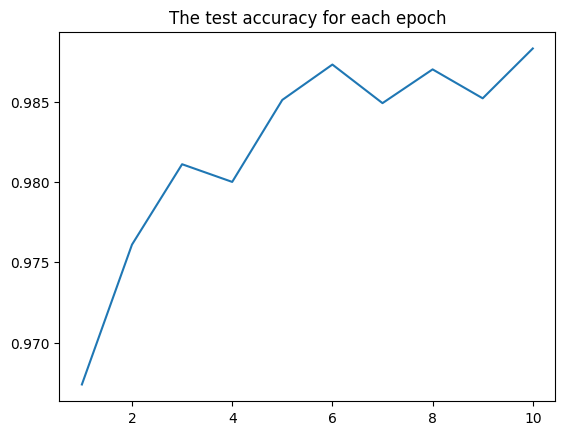

In [9]:
plt.figure()
plt.title("The test accuracy for each epoch")
plt.plot(list(range(1,11)),accuracy_result)